Université Paul Sabatier

EIMAB3H1 - Analyse et exploitation de données

Enseignant : **José G. Moreno**

In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## TP 2. Similarité sémantique multi-niveau

Rappelez vous du calcule de l’ESA (Explicit Semantic Analysis). Notez que pour appliquer cette méthode il faut d'abord construire de vecteurs pour représenter chaque mot. 

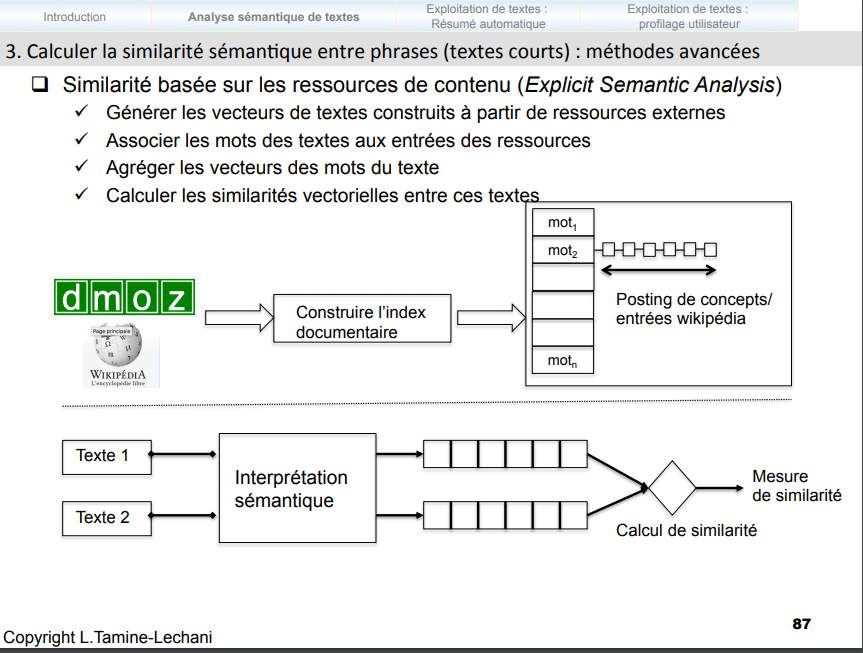

Dans le TP1, nous avons construit de vecteurs pour chaque mot en utilisant la fenêtre de contexte et la PPMI et aussi utilisé les vecteurs appelés word embeddings. Dans ce TP, les vecteurs seront construits en utilisant la fréquence d'un mot dans un document.

### 1. Collection
Utilisez le fichier simplewiki (le code pour le télécharger et le transformer dans un datafram est ci-dessous).

In [3]:
!wget https://dumps.wikimedia.org/simplewiki/20210901/simplewiki-20210901-abstract.xml.gz
!gzip -d simplewiki-20210901-abstract.xml.gz

--2021-10-07 09:27:15--  https://dumps.wikimedia.org/simplewiki/20210901/simplewiki-20210901-abstract.xml.gz
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17650043 (17M) [application/octet-stream]
Saving to: ‘simplewiki-20210901-abstract.xml.gz’

simplewiki-20210901 100%[===================>]  16.83M  4.15MB/s    in 3.9s    

2021-10-07 09:27:19 (4.31 MB/s) - ‘simplewiki-20210901-abstract.xml.gz’ saved [17650043/17650043]



In [4]:
!head -20 simplewiki-20210901-abstract.xml

<feed>
<doc>
<title>Wikipedia: April</title>
<url>https://simple.wikipedia.org/wiki/April</url>
<abstract>April is the fourth month of the year, and comes between March and May. It is one of four months to have 30 days.</abstract>
<links>
<sublink linktype="nav"><anchor>The Month</anchor><link>https://simple.wikipedia.org/wiki/April#The_Month</link></sublink>
<sublink linktype="nav"><anchor>April in poetry</anchor><link>https://simple.wikipedia.org/wiki/April#April_in_poetry</link></sublink>
<sublink linktype="nav"><anchor>Events in April</anchor><link>https://simple.wikipedia.org/wiki/April#Events_in_April</link></sublink>
<sublink linktype="nav"><anchor>Fixed Events</anchor><link>https://simple.wikipedia.org/wiki/April#Fixed_Events</link></sublink>
<sublink linktype="nav"><anchor>Moveable Events</anchor><link>https://simple.wikipedia.org/wiki/April#Moveable_Events</link></sublink>
<sublink linktype="nav"><anchor>Selection of Historical Events</anchor><link>https://simple.wikipedia.or

In [5]:
import xml.etree.ElementTree as et

def parse_XML(xml_file, df_cols): 
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    for node in xroot: 
        #add for full wikipedia
        res = []
        for el in df_cols[0:]: 
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    out_df = pd.DataFrame(rows, columns=df_cols)
    return out_df,node

In [6]:
df,node = parse_XML("simplewiki-20210901-abstract.xml", ["title", "abstract"])
df

,title,abstract
0,Wikipedia: April,"April is the fourth month of the year, and com..."
1,Wikipedia: August,August (Aug.) is the eighth month of the year ...
2,Wikipedia: Art,Art is a creative activity that expresses imag...
3,Wikipedia: A,A or a is the first letter of the English alph...
4,Wikipedia: Air,thumb|A [is used to move air.]
...,...,...
195439,Wikipedia: Jay McGraw,"| birth_place = Wichita County, Texas, ..."
195440,Wikipedia: MonkeyBear and Friends,| channel =
195441,Wikipedia: Veliky Novgorod,Veliky Novgorod () is a city in Russia. It is ...
195442,Wikipedia: Central Airport (movie),Central Airport is a 1933 American adventure d...


### 2. Matrice mot x document 
Pour chaque mot, calculez sa fréquence par rapport à toutes les pages Wikipédia (``` abstract ``` dans le dataframe). Pour le faire, construisez une matrice avec autant de colonnes comme de pages Wikipédia et autant de lignes comme de mots dans le vocabulaire. Chaque position $X_{ij}$ contiendra la fréquence du mot $i$ dans le document $j$. Vous pouvez simplifier la tâche, par exemple, en utilisant uniquement que les 1000 premiers documents dans le dataframe.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(df['abstract'].dropna().values)

In [9]:
# print(vectorizer.get_feature_names())
# print(vectorizer.vocabulary_)
X[0]

<1x155457 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [10]:
abstracts=[abstr.replace('.','').replace(',','').replace('(','').replace(')','').replace(':','').replace('|','').replace('[','').replace(']','').replace('=','').lower() for abstr in df['abstract'].dropna().values]
abstracts[:10]

['april is the fourth month of the year and comes between march and may it is one of four months to have 30 days',
 'august aug is the eighth month of the year in the gregorian calendar coming between july and september',
 'art is a creative activity that expresses imaginative or technical skill it produces a product an object',
 'a or a is the first letter of the english alphabet the small letter a or α is used as a lower case vowel',
 'thumba is used to move air',
 'spain is divided in 17 parts called autonomous communities autonomous means that each of these autonomous communities has its own executive legislative judicial powers',
 'alan mathison turing obe frs london 23 june 1912 – wilmslow cheshire 7 june 1954 was an english mathematician and computer scientist he was born in maida vale london',
 ' death_date   ',
 ' latest release version  cc 2017 210',
 'andouille is a type of pork sausage it is spicy hot in taste and smoked']

In [11]:
N=1000
M=np.zeros((len(vectorizer.vocabulary_),N))
for i,word in enumerate(vectorizer.vocabulary_.keys()):
  for j,abstract in enumerate(abstracts[:N]):
    M[i][j]= abstract.count(word)
M[:10,:10]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 1., 1., 3., 1., 2., 3., 0., 0., 2.],
       [2., 3., 0., 3., 0., 1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 1., 0., 1., 0., 1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 1., 0., 0., 0., 0., 1., 0., 0., 2.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [12]:
X[:10,:10]

<10x10 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

### 3. ESA
Utilisez la [formule d'ESA](https://en.wikipedia.org/wiki/Explicit_semantic_analysis) pour calculer la similarité entre les mots ***leptodactylidae***, ***frog***, ***fish***, ***bird*** et ***dog***. Vos résultats sont-ils cohérents? 

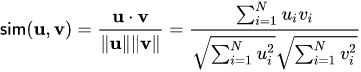

In [13]:
def get_index(mot,texte):
  return texte.index(mot)

get_index('dog',list(vectorizer.vocabulary_.keys()))

9774

In [14]:
vectorizer.vocabulary_['month']

91861

In [15]:
X[0].toarray()[0,91861] #" month dans le 1er document"

1

In [16]:
## ESA
def SIM(u,v):
  return sum(u*v)/np.linalg.norm(u)/np.linalg.norm(v)

words_list=['leptodactylidae', 'frog', 'fish', 'bird','dog']
n=len(words_list)
sim_mat=np.zeros((n,n))
for i,w1 in enumerate(words_list):
  index_w1=vectorizer.vocabulary_[w1]
  for j,w2 in enumerate(words_list):
      index_w2=vectorizer.vocabulary_[w2]
      sim_mat[i][j]=SIM(X[index_w1].toarray()[0],X[index_w2].toarray()[0])

sim_mat

array([[1.        , 0.41516825, 0.26148818, 0.        , 0.        ],
       [0.41516825, 1.        , 0.32568477, 0.        , 0.        ],
       [0.26148818, 0.32568477, 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

### 4. Word embeddings 
Utilisez les vecteurs du TP1 (*word embeddings*) et recalculez les similarités précédentes.

In [17]:
!wget https://github.com/nate-parrott/squad/blob/master/data/glove.6B.50d.txt.zip?raw=true
!unzip glove.6B.50d.txt.zip\?raw\=true

--2021-10-07 09:29:36--  https://github.com/nate-parrott/squad/blob/master/data/glove.6B.50d.txt.zip?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/nate-parrott/squad/raw/master/data/glove.6B.50d.txt.zip [following]
--2021-10-07 09:29:37--  https://github.com/nate-parrott/squad/raw/master/data/glove.6B.50d.txt.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nate-parrott/squad/master/data/glove.6B.50d.txt.zip [following]
--2021-10-07 09:29:37--  https://raw.githubusercontent.com/nate-parrott/squad/master/data/glove.6B.50d.txt.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:

In [18]:
vect = {w.split()[0]:np.array(w.split()[1:]).astype(float) for w in open('glove.6B.50d.txt').readlines()}

In [20]:
## ESA

words_list=['leptodactylidae', 'frog', 'fish', 'bird','dog']
n=len(words_list)
sim_mat=np.zeros((n,n))
for i,w1 in enumerate(words_list):
  v1=vect[w1]
  for j,w2 in enumerate(words_list):
      v2=vect[w2]
      sim_mat[i][j]=SIM(v1,v2)

sim_mat



array([[1.        , 0.59794949, 0.1910499 , 0.30377508, 0.29905588],
       [0.59794949, 1.        , 0.56618131, 0.62135989, 0.63445255],
       [0.1910499 , 0.56618131, 1.        , 0.76385156, 0.6417126 ],
       [0.30377508, 0.62135989, 0.76385156, 1.        , 0.66916223],
       [0.29905588, 0.63445255, 0.6417126 , 0.66916223, 1.        ]])

In [21]:
(vect['dog']) # dense !! peu de dimensions mais ca apporte bcp d'information à l'inverse de la premiere methode
# crosse - > bcp d zeros, indexé facilement les frequences - > perte dinfo

array([ 0.11008  , -0.38781  , -0.57615  , -0.27714  ,  0.70521  ,
        0.53994  , -1.0786   , -0.40146  ,  1.1504   , -0.5678   ,
        0.0038977,  0.52878  ,  0.64561  ,  0.47262  ,  0.48549  ,
       -0.18407  ,  0.1801   ,  0.91397  , -1.1979   , -0.5778   ,
       -0.37985  ,  0.33606  ,  0.772    ,  0.75555  ,  0.45506  ,
       -1.7671   , -1.0503   ,  0.42566  ,  0.41893  , -0.68327  ,
        1.5673   ,  0.27685  , -0.61708  ,  0.64638  , -0.076996 ,
        0.37118  ,  0.1308   , -0.45137  ,  0.25398  , -0.74392  ,
       -0.086199 ,  0.24068  , -0.64819  ,  0.83549  ,  1.2502   ,
       -0.51379  ,  0.04224  , -0.88118  ,  0.7158   ,  0.38519  ])

### 5. Évaluation 
Notez qu'un seul exemple ne nous permet pas de trouver la meilleur méthode/représentation car le résultat peut corresponde à une donnée aberrante. Pour faire une évaluation plus juste, vous pouvez utiliser des collections standards dédiées à ce type de tâches. Par exemple, la collection [SemEval2014task3](http://alt.qcri.org/semeval2014/task3/) contient de pairs de mots et phrases pour lesquelles il faut trouver une valeur de similarité automatiquement. Dans cette collection, la phrase ***loss of air pressure in a tire*** doit être comparée avec la liste de mots ***flat-tire***, ***puncture***, ***tire***, ***parking*** et ***butterfly***, et votre système doit décider un dégré de similarité pour chaque mot. Une évaluation de differentes méthodes est possible car pour chaque mot une valeur de similarité a été donné par un humain. Votre tâche consiste en automatiquement trouver les valeurs de similarité qui correspondent le mieux à une prédiction humaine. Pour le faire :

* Téléchargez le fichier semeval2014task3 avec cette commande


In [22]:
!wget http://alt.qcri.org/semeval2014/task3/data/uploads/semeval-2014_task-3.zip
!unzip semeval-2014_task-3.zip 

--2021-10-07 09:30:00--  http://alt.qcri.org/semeval2014/task3/data/uploads/semeval-2014_task-3.zip
Resolving alt.qcri.org (alt.qcri.org)... 80.76.166.234
Connecting to alt.qcri.org (alt.qcri.org)|80.76.166.234|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://alt.qcri.org/semeval2014/task3/data/uploads/semeval-2014_task-3.zip [following]
--2021-10-07 09:30:01--  https://alt.qcri.org/semeval2014/task3/data/uploads/semeval-2014_task-3.zip
Connecting to alt.qcri.org (alt.qcri.org)|80.76.166.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1567116 (1.5M) [application/zip]
Saving to: ‘semeval-2014_task-3.zip’

semeval-2014_task-3 100%[===================>]   1.49M  1.41MB/s    in 1.1s    

2021-10-07 09:30:03 (1.41 MB/s) - ‘semeval-2014_task-3.zip’ saved [1567116/1567116]

Archive:  semeval-2014_task-3.zip
   creating: SemEval-2014_Task-3/
  inflating: SemEval-2014_Task-3/00-README.txt  
   creating: SemEval-2014_

* Lisez le fichier test/phrase2word.train.input.tsv est calculez la similarité entre chaque pair de phrase et mot avec les méthodes ESA,  Wordnet et  word embeddings.


In [23]:
import pandas as pd

In [24]:
df = pd.DataFrame([x.strip().split('\t') for x in open('SemEval-2014_Task-3/data/test/phrase2word.test.input.tsv')])
df.columns = ['phrase','mot','classe']
df

,phrase,mot,classe
0,dirty business,laundry,Slang-1
1,notch on one's bedpost,mattress,Slang-2
2,four one one,natty,Slang-3
3,road warrior,geek,Slang-4
4,send down,pregnant,Slang-5
...,...,...,...
495,using a bicycle to generate electricity,power,Search-496
496,willy wonka and the chocolate factory birthday...,birthday,Search-497
497,myths and misconceptions about second language...,dancing,Search-498
498,telephones for the hearing impaired,hearing aid,Search-499


* Sauvegardez la similarité pour chaque pair dans un nouveau fichier et appelez-le output.txt (comme dans le code ci-dessous). Chaque valeur doit être dans une nouvelle ligne, donc le nombre de lignes dans le fichier  test/phrase2word.train.input.tsv et le fichier que vous avez crée doit être le même.


In [25]:
df.tail()

,phrase,mot,classe
495,using a bicycle to generate electricity,power,Search-496
496,willy wonka and the chocolate factory birthday...,birthday,Search-497
497,myths and misconceptions about second language...,dancing,Search-498
498,telephones for the hearing impaired,hearing aid,Search-499
499,battle that was a turning point for europe,tipping point,Search-500


In [26]:
# ESA
similarity: list =[]
n=df.shape[0]
for ligne in df.itertuples():
  w1=ligne.mot
  if type(ligne.phrase)==str:
    words_list=ligne.phrase.replace('.','').replace(',','').replace('(','').replace(')','').replace('\'','').replace(':','').replace('|','').replace('[','').replace(']','').replace('=','').lower().split()
  try:
    v1=vect[w1]
    sim_mat=np.zeros(len(words_list))
    for j,w2 in enumerate(words_list):
      v2=vect[w2]
      sim_mat[j]=SIM(v1,v2)
    similarity.append(np.mean(sim_mat))
  except:
    similarity.append(0)
    pass

df['similarite_ESA']=similarity.copy()
df['similarite_ESA'].to_csv('output_ESA.txt',header=None,index=False)


In [27]:
# wordnet
similarity_wn: list =[]
n=df.shape[0]
for ligne in df.itertuples():
  w1=ligne.mot
  if type(ligne.phrase)==str:
    words_list=ligne.phrase.replace('.','').replace(',','').replace('(','').replace(')','').replace('\'','').replace(':','').replace('|','').replace('[','').replace(']','').replace('=','').lower().split()
  try:
    v1=wordnet.synsets(w1)[0] 
    sim_mat=np.zeros(len(words_list))
    for j,w2 in enumerate(words_list):
      sim_mat[j]=v1.path_similarity(wordnet.synsets(w2)[0])
    similarity_wn.append(np.mean(sim_mat))
  except:
    similarity_wn.append(0)
    pass


df['similarite_wordnet']=similarity_wn.copy()


In [28]:
df.isna().sum() 

phrase                 0
mot                    0
classe                 0
similarite_ESA         0
similarite_wordnet    78
dtype: int64

In [29]:
df=df.fillna(0)
print(df.isna().sum() )
df['similarite_wordnet'].to_csv('output_wordnet.txt',header=None,index=False)


phrase                0
mot                   0
classe                0
similarite_ESA        0
similarite_wordnet    0
dtype: int64


In [35]:
df.head()

,phrase,mot,classe,similarite_ESA,similarite_wordnet
0,dirty business,laundry,Slang-1,0.524970,0.00
1,notch on one's bedpost,mattress,Slang-2,0.147206,0.00
2,four one one,natty,Slang-3,-0.292596,0.00
3,road warrior,geek,Slang-4,0.127809,0.15
4,send down,pregnant,Slang-5,0.310647,0.00


In [34]:
df.sample(16)

,phrase,mot,classe,similarite_ESA,similarite_wordnet
309,Azul check-in counter at Viracopos Internation...,holiday,Descriptive-310,0.000000,0.000000
105,banana hammock,fruit,Slang-106,0.457786,0.087121
286,low blow,insult,Idiomatic-287,0.273428,0.069712
94,have a blast,enjoy,Slang-95,0.336680,0.105303
379,lymph node with almost complete replacement by...,coke,Descriptive-380,0.094227,0.000000
426,a freeware web browser developed by Google,chrome,Lexicographic-427,0.268177,0.000000
177,obviously hurting,pleasure,Newswire-178,0.408971,0.000000
274,cut a rug,cloud,Idiomatic-275,0.323302,0.077228
390,a plant that is valued for qualities such as m...,aloe,Lexicographic-391,0.036045,0.000000
319,the estuary of the River Camel looking seaward...,lens,Descriptive-320,0.146608,0.000000


* Évaluez la performance en utilisant la commande

In [31]:
!java -jar SemEval-2014_Task-3/evaluation/task-3-scorer.jar SemEval-2014_Task-3/keys/test/phrase2word.test.gs.tsv output_ESA.txt

Scores for SemEval-2014 Task 3
Pearson's correlation	0.075286	Spearman's rho	0.063003


In [32]:
!java -jar SemEval-2014_Task-3/evaluation/task-3-scorer.jar SemEval-2014_Task-3/keys/test/phrase2word.test.gs.tsv output_wordnet.txt

Scores for SemEval-2014 Task 3
Pearson's correlation	0.154180	Spearman's rho	0.157016


* Vous avez un fichier de test pour l’évaluation dans de dossier baselines. Si vous utilisez la commande
```
!java -jar SemEval-2014_Task-3/evaluation/task-3-scorer.jar SemEval-2014_Task-3/keys/test/phrase2word.test.gs.tsv SemEval-2014_Task-3/keys/baselines/phrase2word.test.baseline.tsv
```
Vous devez avoir comme résultat
```
Scores for SemEval-2014 Task 3
Pearson's correlation	0.164760	Spearman's rho	0.161558
```
Ce dernier resultat est supérieur à l'example précedent mais il n'est pas très performant

In [33]:
!java -jar SemEval-2014_Task-3/evaluation/task-3-scorer.jar SemEval-2014_Task-3/keys/test/phrase2word.test.gs.tsv SemEval-2014_Task-3/keys/baselines/phrase2word.test.baseline.tsv


Scores for SemEval-2014 Task 3
Pearson's correlation	0.164760	Spearman's rho	0.161558


* Renseignez-vous sur les deux métriques utilisées. 
* Évaluez chaque méthode de représentation sémantique (ESA, Wordnet ou  word embeddings). Quelle méthode  donne les meilleurs résultats ?